<!--<badge>--><a href="https://colab.research.google.com/github/nlp-with-transformers/notebooks/blob/main/10_transformers-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [ ]:
# hide
from utils import *
setup_chapter()

# Training Transformers from Scratch

## Large Datasets and Where to Find Them

### Challenges of Building a Large-Scale Corpus

In [ ]:
#hide_output
from transformers import pipeline, set_seed

generation_gpt = pipeline("text-generation", model="openai-gpt")
generation_gpt2 = pipeline("text-generation", model="gpt2")

In [ ]:
def model_size(model):
    return sum(t.numel() for t in model.parameters())

print(f"GPT  size: {model_size(generation_gpt.model)/1000**2:.1f}M parameters")
print(f"GPT2 size: {model_size(generation_gpt2.model)/1000**2:.1f}M parameters")

GPT  size: 116.5M parameters
GPT2 size: 124.4M parameters


In [ ]:
# hide
set_seed(1)

In [ ]:
def enum_pipeline_ouputs(pipe, prompt, num_return_sequences):
    out = pipe(prompt, num_return_sequences=num_return_sequences,
               clean_up_tokenization_spaces=True)
    return "\n".join(f"{i+1}." + s["generated_text"] for i, s in enumerate(out))

prompt = "\nWhen they came back"
print("GPT completions:\n" + enum_pipeline_ouputs(generation_gpt, prompt, 3))
print("")
print("GPT-2 completions:\n" + enum_pipeline_ouputs(generation_gpt2, prompt, 3))

GPT completions:
1.
When they came back.
 " we need all we can get, " jason said once they had settled into the back of
the truck without anyone stopping them. " after getting out here, it 'll be up
to us what to find. for now
2.
When they came back.
 his gaze swept over her body. he 'd dressed her, too, in the borrowed clothes
that she 'd worn for the journey.
 " i thought it would be easier to just leave you there. " a woman like
3.
When they came back to the house and she was sitting there with the little boy.
 " don't be afraid, " he told her. she nodded slowly, her eyes wide. she was so
lost in whatever she discovered that tom knew her mistake

GPT-2 completions:
1.
When they came back we had a big dinner and the other guys went to see what
their opinion was on her. I did an hour and they were happy with it.
2.
When they came back to this island there had been another massacre, but he could
not help but feel pity for the helpless victim who had been left to die, and
that they had 

### Building a Custom Code Dataset


#### Creating a dataset with Google BigQuery

#sidebar To Filter the Noise or Not?

### Working with Large Datasets

#### Memory mapping

In [ ]:
#hide_output
from datasets import load_dataset, DownloadConfig

download_config = DownloadConfig(delete_extracted=True)
dataset = load_dataset("./codeparrot", split="train",
                       download_config=download_config)

In [ ]:
import psutil, os

print(f"Number of python files code in dataset : {len(dataset)}")
ds_size = sum(os.stat(f["filename"]).st_size for f in dataset.cache_files)
# os.stat.st_size is expressed in bytes, so we convert to GB
print(f"Dataset size (cache file) : {ds_size / 2**30:.2f} GB")
# Process.memory_info is expressed in bytes, so we convert to MB
print(f"RAM used: {psutil.Process(os.getpid()).memory_info().rss >> 20} MB")

Number of python files code in dataset : 18695559
Dataset size (cache file) : 183.68 GB
RAM memory used: 4924 MB


#### Streaming

In [ ]:
# hide_output
streamed_dataset = load_dataset('./codeparrot', split="train", streaming=True)

Using custom data configuration default-cae7a1d2f0dbde67


In [ ]:
iterator = iter(streamed_dataset)

print(dataset[0] == next(iterator))
print(dataset[1] == next(iterator))

True
True


In [ ]:
remote_dataset = load_dataset('transformersbook/codeparrot', split="train",
                              streaming=True)

### Adding Datasets to the Hugging Face Hub

## Building a Tokenizer

In [ ]:
# hide_output
from transformers import AutoTokenizer

def tok_list(tokenizer, string):
    input_ids = tokenizer(string, add_special_tokens=False)["input_ids"]
    return [tokenizer.decode(tok) for tok in input_ids]

tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base")
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

In [ ]:
print(f'T5 tokens for "sex": {tok_list(tokenizer_T5,"sex")}')
print(f'CamemBERT tokens for "being": {tok_list(tokenizer_camembert,"being")}')

T5 tokens for "sex": ['', 's', 'ex']
CamemBERT tokens for "being": ['be', 'ing']


### The Tokenizer Model

### Measuring Tokenizer Performance

### A Tokenizer for Python 

In [ ]:
from transformers import AutoTokenizer

python_code = r"""def say_hello():
    print("Hello, World!")
# Print it
say_hello()
"""
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("',
'Hello', ',', 'ĠWorld', '!"', ')', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_',
'hello', '()', 'Ċ']


In [ ]:
print(tokenizer.backend_tokenizer.normalizer)

None


In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():',
(13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello',
(28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ġ#', (43,
45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('Ċ', (55, 56)),
('say', (56, 59)), ('_', (59, 60)), ('hello', (60, 65)), ('()', (65, 67)), ('Ċ',
(67, 68))]


In [ ]:
a, e = u"a", u"€"
byte = ord(a.encode("utf-8"))
print(f'`{a}` is encoded as `{a.encode("utf-8")}` with a single byte: {byte}')
byte = [ord(chr(i)) for i in e.encode("utf-8")]
print(f'`{e}` is encoded as `{e.encode("utf-8")}` with three bytes: {byte}')

`a` is encoded as `b'a'` with a single byte: 97
`€` is encoded as `b'\xe2\x82\xac'` with three bytes: [226, 130, 172]


In [ ]:
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

print(f'Size of our base vocabulary: {len(base_vocab)}')
print(f'First element: `{base_vocab[0]}`, last element: `{base_vocab[-1]}`')

Size of our base vocabulary: 256
First element: `!`, last element: `Ń`


In [ ]:
# hide_input
#id unicode_mapping
#caption Examples of character mappings in BPE
#hide_input
import pandas as pd
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

examples = [
    ['Regular characters', '`a` and `?`', f'{ord("a")} and {ord("?")}' , f'`{byte_to_unicode_map[ord("a")]}` and `{byte_to_unicode_map[ord("?")]}`'],
    ['Nonprintable control character (carriage return)', '`U+000D`', f'13', f'`{byte_to_unicode_map[13]}`'],
    ['A space', '` `', f'{ord(" ")}', f'`{byte_to_unicode_map[ord(" ")]}`'],
    ['A nonbreakable space', '`\\xa0`', '160', f'`{byte_to_unicode_map[ord(chr(160))]}`'],
    ['A newline character', '`\\n`', '10', f'`{byte_to_unicode_map[ord(chr(10))]}`'],
]

display_df(pd.DataFrame(examples, columns = ['Description', 'Character', 'Bytes', 'Mapped bytes']), index=None)

Description,Character,Bytes,Mapped bytes
Regular characters,`a` and `?`,97 and 63,`a` and `?`
Non-printable control character (CARRIAGE RETURN),`U+000D`,13,`č`
A space,` `,32,`Ġ`
A non-breakable space,`\xa0`,160,`ł`
A newline character,`\n`,10,`Ċ`


In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():',
(13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello',
(28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ġ#', (43,
45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('Ċ', (55, 56)),
('say', (56, 59)), ('_', (59, 60)), ('hello', (60, 65)), ('()', (65, 67)), ('Ċ',
(67, 68))]


In [ ]:
print(f"Size of the vocabulary: {len(tokenizer)}")

Size of the vocabulary: 50257


In [ ]:
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("',
'Hello', ',', 'ĠWorld', '!"', ')', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_',
'hello', '()', 'Ċ']


### Training a Tokenizer

In [ ]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: len(x[0]), reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:8]]);

['ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ', '
=================================================================', '
----------------------------------------------------------------',
'................................................................',
'ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ',
'----------------------------------------------------------------',
'================================================================',
'________________________________________________________________']


In [ ]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:12]]);

['<|endoftext|>', ' gazed', ' informants', ' Collider', ' regress', 'ominated',
' amplification', 'Compar', '…."', ' (/', 'Commission', ' Hitman']


In [ ]:
#hide_output
from tqdm.auto import tqdm

length = 100000
dataset_name = 'transformersbook/codeparrot-train'
dataset = load_dataset(dataset_name, split="train", streaming=True)
iter_dataset = iter(dataset)

def batch_iterator(batch_size=10):
    for _ in tqdm(range(0, length, batch_size)):
        yield [next(iter_dataset)['content'] for _ in range(batch_size)]

new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), 
                                                  vocab_size=12500,
                                                  initial_alphabet=base_vocab)

Check remote data files:   0%|          | 0/183 [00:00<?, ?it/s]

Using custom data configuration codeparrot-train-99775fd6743284b5


In [ ]:
tokens = sorted(new_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[257:280]]);

['  ', '    ', '   ', '        ', 'se', 'in', '       ', 're', 'on', 'te', '\n
', '\n        ', 'or', 'st', 'de', '\n   ', 'th', 'le', ' =', 'lf', 'self',
'me', 'al']


In [ ]:
print([f'{new_tokenizer.convert_tokens_to_string(t)}' for t,_ in tokens[-12:]]);

[' capt', ' embedded', ' regarding', 'Bundle', '355', ' recv', ' dmp', ' vault',
' Mongo', ' possibly', 'implementation', 'Matches']


In [ ]:
print(new_tokenizer(python_code).tokens())

['def', 'Ġs', 'ay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',',
'ĠWor', 'ld', '!")', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 's', 'ay', '_', 'hello',
'()', 'Ċ']


In [ ]:
import keyword

print(f'There are in total {len(keyword.kwlist)} Python keywords.')
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer.vocab:
        print(f'No, keyword `{keyw}` is not in the vocabulary')

There are in total 35 Python keywords.
No, keyword `await` is not in the vocabulary
No, keyword `finally` is not in the vocabulary
No, keyword `nonlocal` is not in the vocabulary


In [ ]:
# hide_output
length = 200000
new_tokenizer_larger = tokenizer.train_new_from_iterator(batch_iterator(),
    vocab_size=32768, initial_alphabet=base_vocab)

100%|██████████| 200/200 [05:08<00:00,  1.54s/it]


In [ ]:
tokens = sorted(new_tokenizer_larger.vocab.items(), key=lambda x: x[1],
                reverse=False)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[-12:]]);

['lineEdit', 'spik', ' BC', 'pective', 'OTA', 'theus', 'FLUSH', ' excutils',
'00000002', ' DIVISION', 'CursorPosition', ' InfoBar']


In [ ]:
print(new_tokenizer_larger(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',',
'ĠWorld', '!")', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_', 'hello', '()',
'Ċ']


In [ ]:
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer_larger.vocab:
        print(f'No, keyword `{keyw}` is not in the vocabulary')

No, keyword `nonlocal` is not in the vocabulary


### Saving a Custom Tokenizer on the Hub

In [ ]:
#hide_output
model_ckpt = "codeparrot"
org = "transformersbook"
new_tokenizer_larger.push_to_hub(model_ckpt, organization=org)

Cloning https://huggingface.co/transformersbook/codeparrot into local empty directory.


'https://huggingface.co/transformersbook/codeparrot/commit/1c284adaa3cc9f8635ae7e3377bd3739f48bc09a'

In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained(org + "/" + model_ckpt)
print(reloaded_tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',',
'ĠWorld', '!")', 'Ġ#', 'ĠPrint', 'Ġit', 'Ċ', 'Ċ', 'say', '_', 'hello', '()',
'Ċ']


In [ ]:
#hide_output
new_tokenizer.push_to_hub(model_ckpt+ "-small-vocabulary", organization=org)

Cloning https://huggingface.co/transformersbook/codeparrot-small-vocabulary into local empty directory.


'https://huggingface.co/transformersbook/codeparrot-small-vocabulary/commit/0b37bed9956d95d0b79ada169f6a281e15c63381'

## Training a Model from Scratch

### A Tale of Pretraining Objectives

#### Causal language modeling

#### Masked language modeling

#### Sequence-to-sequence training

### Initializing the Model

In [ ]:
#hide_output
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained("gpt2-xl", vocab_size=len(tokenizer))
model = AutoModelForCausalLM.from_config(config)

Downloading:   0%|          | 0.00/787 [00:00<?, ?B/s]

In [ ]:
print(f'GPT-2 (xl) size: {model_size(model)/1000**2:.1f}M parameters')

GPT-2 (xl) size: 1529.6M parameters


In [ ]:
#hide_output
model.save_pretrained("models/" + model_ckpt, push_to_hub=True,
                      organization=org)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config_small = AutoConfig.from_pretrained("gpt2", vocab_size=len(tokenizer))
model_small = AutoModelForCausalLM.from_config(config_small)

In [ ]:
print(f'GPT-2 size: {model_size(model_small)/1000**2:.1f}M parameters')

GPT-2 size: 111.0M parameters


In [ ]:
#hide_output
model_small.save_pretrained("models/" + model_ckpt + "-small", push_to_hub=True,
                            organization=org)

Cloning https://huggingface.co/transformersbook/codeparrot-small into local empty directory.


### Implementing the Dataloader

In [ ]:
#hide_output
examples, total_characters, total_tokens = 500, 0, 0
dataset = load_dataset('transformersbook/codeparrot-train', split='train',
                       streaming=True)

for _, example in tqdm(zip(range(examples), iter(dataset)), total=examples):
    total_characters += len(example['content'])
    total_tokens += len(tokenizer(example['content']).tokens())

characters_per_token = total_characters / total_tokens

100%|██████████| 500/500 [00:04<00:00, 122.59it/s]


In [ ]:
print(characters_per_token)

3.6233025034779565


In [ ]:
import torch
from torch.utils.data import IterableDataset

class ConstantLengthDataset(IterableDataset):
    
    def __init__(self, tokenizer, dataset, seq_length=1024,
                 num_of_sequences=1024, chars_per_token=3.6):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.eos_token_id
        self.dataset = dataset
        self.seq_length = seq_length
        self.input_characters = seq_length * chars_per_token * num_of_sequences
    
    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.input_characters:
                    m=f"Buffer full: {buffer_len}>={self.input_characters:.0f}"
                    print(m)
                    break
                try:
                    m=f"Fill buffer: {buffer_len}<{self.input_characters:.0f}"
                    print(m)
                    buffer.append(next(iterator)["content"])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    iterator = iter(self.dataset)

            all_token_ids = []
            tokenized_inputs = self.tokenizer(buffer, truncation=False)
            for tokenized_input in tokenized_inputs['input_ids']:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])
            
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    yield torch.tensor(input_ids)

In [ ]:
shuffled_dataset = dataset.shuffle(buffer_size=100)
constant_length_dataset = ConstantLengthDataset(tokenizer, shuffled_dataset,
                                                num_of_sequences=10)
dataset_iterator = iter(constant_length_dataset)

lengths = [len(b) for _, b in zip(range(5), dataset_iterator)]
print(f"Lengths of the sequences: {lengths}")

Fill buffer: 0<36864
Fill buffer: 3311<36864
Fill buffer: 9590<36864
Fill buffer: 22177<36864
Fill buffer: 25530<36864
Fill buffer: 31098<36864
Fill buffer: 32232<36864
Fill buffer: 33867<36864
Buffer full: 41172>=36864
Lengths of the sequences: [1024, 1024, 1024, 1024, 1024]


### Defining the Training Loop

In [ ]:
from argparse import Namespace

# Commented parameters correspond to the small model
config = {"train_batch_size": 2, # 12
          "valid_batch_size": 2, # 12
          "weight_decay": 0.1,
          "shuffle_buffer": 1000,
          "learning_rate": 2e-4, # 5e-4
          "lr_scheduler_type": "cosine",
          "num_warmup_steps": 750, # 2000
          "gradient_accumulation_steps": 16, # 1
          "max_train_steps": 50000, # 150000
          "max_eval_steps": -1,
          "seq_length": 1024,
          "seed": 1,
          "save_checkpoint_steps": 50000} # 15000

args = Namespace(**config)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import logging
import wandb

def setup_logging(project_name):
    logger = logging.getLogger(__name__)
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO, handlers=[
        logging.FileHandler(f"log/debug_{accelerator.process_index}.log"),
        logging.StreamHandler()])
    if accelerator.is_main_process: # We only want to set up logging once
        wandb.init(project=project_name, config=args)
        run_name = wandb.run.name
        tb_writer = SummaryWriter()
        tb_writer.add_hparams(vars(args), {'0': 0})
        logger.setLevel(logging.INFO)
        datasets.utils.logging.set_verbosity_debug()
        transformers.utils.logging.set_verbosity_info()
    else:
        tb_writer = None
        run_name = ''
        logger.setLevel(logging.ERROR)
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    return logger, tb_writer, run_name

In [ ]:
def log_metrics(step, metrics):
    logger.info(f"Step {step}: {metrics}")
    if accelerator.is_main_process:
        wandb.log(metrics)
        [tb_writer.add_scalar(k, v, step) for k, v in metrics.items()]

In [ ]:
#hide_output
from torch.utils.data.dataloader import DataLoader

def create_dataloaders(dataset_name):
    train_data = load_dataset(dataset_name+'-train', split="train",
                              streaming=True)
    train_data = train_data.shuffle(buffer_size=args.shuffle_buffer,
                                    seed=args.seed)
    valid_data = load_dataset(dataset_name+'-valid', split="validation",
                              streaming=True)
    
    train_dataset = ConstantLengthDataset(tokenizer, train_data,
                                          seq_length=args.seq_length)
    valid_dataset = ConstantLengthDataset(tokenizer, valid_data,
                                          seq_length=args.seq_length)
    
    train_dataloader=DataLoader(train_dataset, batch_size=args.train_batch_size)
    eval_dataloader=DataLoader(valid_dataset, batch_size=args.valid_batch_size)
    return train_dataloader, eval_dataloader

Check remote data files:   0%|          | 0/183 [00:00<?, ?it/s]

Using custom data configuration codeparrot-train-938ce362e6f661b1
Using custom data configuration codeparrot-valid-29167601d8e69487


In [ ]:
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [{'params': params_with_wd, 'weight_decay': args.weight_decay},
            {'params': params_without_wd, 'weight_decay': 0.0}]

In [ ]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch, labels=batch)
        loss = outputs.loss.repeat(args.valid_batch_size)
        losses.append(accelerator.gather(loss))
        if args.max_eval_steps > 0 and step >= args.max_eval_steps: break
    loss = torch.mean(torch.cat(losses))
    try:
		perplexity = torch.exp(loss)
	except OverflowError:
		perplexity = torch.tensor(float("inf"))
    return loss.item(), perplexity.item()

In [ ]:
set_seed(args.seed)

# Accelerator
accelerator = Accelerator()
samples_per_step = accelerator.state.num_processes * args.train_batch_size

# Logging
logger, tb_writer, run_name = setup_logging(project_name.split("/")[1])
logger.info(accelerator.state)

# Load model and tokenizer
if accelerator.is_main_process:
    hf_repo = Repository("./", clone_from=project_name, revision=run_name)
model = AutoModelForCausalLM.from_pretrained("./", gradient_checkpointing=True)
tokenizer = AutoTokenizer.from_pretrained("./")

# Load dataset and dataloader
train_dataloader, eval_dataloader = create_dataloaders(dataset_name)

# Prepare the optimizer and learning rate scheduler
optimizer = AdamW(get_grouped_params(model), lr=args.learning_rate)
lr_scheduler = get_scheduler(name=args.lr_scheduler_type, optimizer=optimizer,
                             num_warmup_steps=args.num_warmup_steps,
                             num_training_steps=args.max_train_steps,)
def get_lr():
    return optimizer.param_groups[0]['lr']

# Prepare everything with our `accelerator` (order of args is not important)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader)

# Train model
model.train()
completed_steps = 0
for step, batch in enumerate(train_dataloader, start=1):
    loss = model(batch, labels=batch).loss
    log_metrics(step, {'lr': get_lr(), 'samples': step*samples_per_step,
                       'steps': completed_steps, 'loss/train': loss.item()})
    loss = loss / args.gradient_accumulation_steps
    accelerator.backward(loss)
    if step % args.gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    if step % args.save_checkpoint_steps == 0:
        logger.info('Evaluating and saving model checkpoint')
        eval_loss, perplexity = evaluate()
        log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        if accelerator.is_main_process:
            unwrapped_model.save_pretrained("./")
            hf_repo.push_to_hub(commit_message=f'step {step}')
        model.train()
    if completed_steps >= args.max_train_steps:
        break

# Evaluate and save the last checkpoint
logger.info('Evaluating and saving model after training')
eval_loss, perplexity = evaluate()
log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
if accelerator.is_main_process:
    unwrapped_model.save_pretrained("./")
    hf_repo.push_to_hub(commit_message=f'final model')

### The Training Run

## Results and Analysis

In [ ]:
# hide
import wandb
import pandas as pd
import matplotlib.pyplot as plt

api = wandb.Api()

run = api.run("lvwerra/codeparrot-small/2654p8r7")
df_small = pd.DataFrame([row for row in run.scan_history()])

run = api.run(f"lvwerra/codeparrot/36cw69uv")
df_large = pd.DataFrame([row for row in run.scan_history()])

df_large['tokens'] = 1024 * df_large['samples']
df_small['tokens'] = 1024 * df_small['samples']

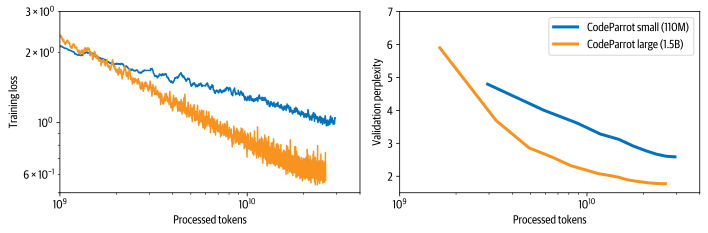

In [ ]:
# hide_input

#id training_result
#alt Training loss and validation perplexity.
#caption Training loss and validation perplexity as a function of processed tokens for the small and large CodeParrot models 

def plot_loss(df, color, label='', steps=100, ax=None):
    df_tmp = df.set_index('tokens')
    m = df_tmp['loss/train'].rolling(steps, center=True).agg({'mean':'mean', 'std':'std'})
    ax = m['mean'].ffill().plot(color=color, label=label, ax=ax)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

steps = 1000
plot_loss(df_small, 'C0', 'CodeParrot small (110M)', steps=steps, ax=axes[0])
plot_loss(df_large, 'C1', 'CodeParrot large (1.5B)', steps=steps, ax=axes[0])
#axes[0].legend(loc='best')
axes[0].set_ylabel('Training loss')
axes[0].set_xlabel('Processed tokens')
axes[0].set_yscale('log')
axes[0].set_xscale('log')

#plt.xscale('linear')
axes[0].set_xlim(left=1e9, right=4e10);
axes[0].set_ylim(bottom=0.5, top=3);

df_tmp_small = df_small.copy()
df_tmp_small['tokens'] = df_tmp_small['tokens'].fillna(method='ffill')
df_tmp_small.dropna(subset=['perplexity'], inplace=True)

df_tmp_large = df_large.copy()
df_tmp_large['tokens'] = df_tmp_large['tokens'].fillna(method='ffill')
df_tmp_large.dropna(subset=['perplexity'], inplace=True)

df_tmp_small.plot(x='tokens', y='perplexity', label='CodeParrot small (110M)', linewidth=3., ax=axes[1])
df_tmp_large.plot(x='tokens', y='perplexity', ax=axes[1], label='CodeParrot large (1.5B)', linewidth=3.,)
axes[1].set_xscale('log')
#axes[1].set_yscale('log')
axes[1].set_xlabel('Processed tokens')
axes[1].set_ylabel('Validation perplexity')
axes[1].set_xlim([1e9, 4e10])
axes[1].set_ylim([1.5, 7])
plt.tight_layout()
plt.show()

In [ ]:
#hide_output
from transformers import pipeline, set_seed

model_ckpt = 'transformersbook/codeparrot-small'
generation = pipeline('text-generation', model=model_ckpt, device=0)

2021-10-20 18:29:01.107727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-20 18:29:01.107759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
import re
from transformers import set_seed 

def first_block(string):
    return re.split('\nclass|\ndef|\n#|\n@|\nprint|\nif', string)[0].rstrip()

def complete_code(pipe, prompt, max_length=64, num_completions=4, seed=1):
    set_seed(seed)
    gen_kwargs = {"temperature":0.4, "top_p":0.95, "top_k":0, "num_beams":1,
                  "do_sample":True,}
    code_gens = generation(prompt, num_return_sequences=num_completions, 
                            max_length=max_length, **gen_kwargs)
    code_strings = []
    for code_gen in code_gens:
        generated_code = first_block(code_gen['generated_text'][len(prompt):])
        code_strings.append(generated_code)
    print(('\n'+'='*80 + '\n').join(code_strings))

In [ ]:
prompt = '''def area_of_rectangle(a: float, b: float):
    """Return the area of the rectangle."""'''
complete_code(generation, prompt)


    return math.sqrt(a * b)

    return a * b / 2.0

    return a * b

    return a * b / a


In [ ]:
prompt = '''def get_urls_from_html(html):
    """Get all embedded URLs in a HTML string."""'''
complete_code(generation, prompt)


    if not html:
        return []
    return [url for url in re.findall(r'<a href="(/[^/]+/[^"]+?)">', html)]

    return [url for url in re.findall(r'<a href="(.*?)"', html)
            if url]

    return [url for url in re.findall(r'<a href="(/.*)",', html)]

    return re.findall(r'<a href="(.*?)" class="url"[^>]*>', html)


In [ ]:
import requests

def get_urls_from_html(html):
    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

print(" | ".join(get_urls_from_html(requests.get('https://hf.co/').text)))

https://github.com/huggingface/transformers | /allenai | /facebook |
/asteroid-team | /google | /amazon | /speechbrain | /microsoft | /grammarly |
/models | /inference-api | /distilbert-base-uncased |
/dbmdz/bert-large-cased-finetuned-conll03-english |
https://huggingface.co/transformers | https://arxiv.org/abs/1811.06031 |
https://arxiv.org/abs/1803.10631 | https://transformer.huggingface.co/ | /coref
| https://medium.com/huggingface/distilbert-8cf3380435b5


In [ ]:
model_ckpt = 'transformersbook/codeparrot'
generation = pipeline('text-generation', model=model_ckpt, device=0)

prompt = '''# a function in native python:
def mean(a):
    return sum(a)/len(a)

# the same function using numpy:
import numpy as np
def mean(a):'''
complete_code(generation, prompt, max_length=64)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



    return np.mean(a)

    return np.mean(a)

    return np.mean(a)

    return np.mean(a)


In [ ]:
prompt = '''X = np.random.randn(100, 100)
y = np.random.randint(0, 1, 100)

# fit random forest classifier with 20 estimators'''
complete_code(generation, prompt, max_length=96)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



reg = DummyRegressor()

forest = RandomForestClassifier(n_estimators=20)

forest.fit(X, y)

clf = ExtraTreesClassifier(n_estimators=100, max_features='sqrt')
clf.fit(X, y)

clf = RandomForestClassifier(n_estimators=20, n_jobs=n_jobs, random_state=1)
clf.fit(X, y)

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X, y)


## Conclusion